Business Objective
Advertisers use various online marketing channels to reach consumers, and they
typically want to know how much each channel contributes to their marketing
success. This is what is known as multi-channel attribution.

In many cases, advertisers approach this problem using simple models that help
them understand the importance of each marketing channel.

In this project, different types of models are built to help understand the channles that lead to greater customer conversion. This wil imporove the advertising ROI 
by quantifying the actual value of the multi-faceted advertising campaigns. This will enable business stakeholders
to make decisions based on the millions of converting click paths by isolating theimpact of every touchpoint.

The project aims at building multiple attribution models on the given dataset to discover channels leading to greater customer conversions.


IMPORT PACKAGES 

In [27]:
#!pip install gekko
#!pip install -U pandas-profiling

In [28]:
!pip install --upgrade matplotlib


In [29]:
import pandas as pd
import itertools
from collections import defaultdict
from itertools import permutations,combinations
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
from gekko import GEKKO
#from pandas_profiling import ProfileReport
from PIL import Image
import requests
import datetime as dt

## DATA IMPORTATION 

In [30]:
df = pd.read_csv('/Users/chetanhalai/Desktop/Touch-Attribution-models-and-Marketing-spend-Optimization/data/attribution_data.csv')

Sanity Check (Data Validation)

In [31]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [32]:
df.tail()

,cookie,time,interaction,conversion,conversion_value,channel
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display
586733,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:54Z,impression,0,0.0,Online Display
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search


**Observation**

- Overview of the data . The first and last 5 rows look similar 

**Checking the dimensions of the data**

In [33]:
df.shape

(586737, 6)

**Observation**

- 586737 rows and 6 columns


**Checking and Verifying data types**

In [34]:
df.dtypes

cookie               object
time                 object
interaction          object
conversion            int64
conversion_value    float64
channel              object
dtype: object

**Observation**

- All the columns have the correct data types, except the 'time' which needs to be a time series 

In [35]:
df.time

0         2018-07-03T13:02:11Z
1         2018-07-17T19:15:07Z
2         2018-07-24T15:51:46Z
3         2018-07-29T07:44:51Z
4         2018-07-03T09:44:57Z
                  ...         
586732    2018-07-12T23:50:45Z
586733    2018-07-12T23:50:54Z
586734    2018-07-03T12:57:25Z
586735    2018-07-19T08:17:59Z
586736    2018-07-14T17:17:12Z
Name: time, Length: 586737, dtype: object

In [36]:
df['time'] = pd.to_datetime(df['time'])

In [37]:
df.time

0        2018-07-03 13:02:11+00:00
1        2018-07-17 19:15:07+00:00
2        2018-07-24 15:51:46+00:00
3        2018-07-29 07:44:51+00:00
4        2018-07-03 09:44:57+00:00
                    ...           
586732   2018-07-12 23:50:45+00:00
586733   2018-07-12 23:50:54+00:00
586734   2018-07-03 12:57:25+00:00
586735   2018-07-19 08:17:59+00:00
586736   2018-07-14 17:17:12+00:00
Name: time, Length: 586737, dtype: datetime64[ns, UTC]

In [38]:
df.dtypes

cookie                           object
time                datetime64[ns, UTC]
interaction                      object
conversion                        int64
conversion_value                float64
channel                          object
dtype: object

**Checking for Missing Values**


In [39]:
df.isnull().sum()

cookie              0
time                0
interaction         0
conversion          0
conversion_value    0
channel             0
dtype: int64

**Observation**
There apprears to be no missing values 

**Checking for Duplicates**

In [40]:
df.duplicated().sum()

4145

In [41]:
df[df.duplicated()]

,cookie,time,interaction,conversion,conversion_value,channel
92,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-16 13:31:54+00:00,impression,0,0.0,Online Video
94,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-16 13:32:19+00:00,impression,0,0.0,Online Video
178,0037ok3iD0h3kkEDCB0nk9iko,2018-07-11 11:54:56+00:00,impression,0,0.0,Online Video
181,0037ok3iD0h3kkEDCB0nk9iko,2018-07-11 11:55:46+00:00,impression,0,0.0,Online Video
184,0037ok3iD0h3kkEDCB0nk9iko,2018-07-11 11:55:49+00:00,impression,0,0.0,Online Video
...,...,...,...,...,...,...
585931,ooFfnA3E9k39hCCkk9A7ABiCf,2018-07-03 11:54:36+00:00,impression,0,0.0,Online Video
586037,oofEk3DkD3Bn9CA3nChFih3Ff,2018-07-20 18:45:35+00:00,impression,0,0.0,Paid Search
586127,ooh93E3D9EiCDhC7DnFEEFiA3,2018-07-10 06:50:06+00:00,impression,0,0.0,Online Video
586402,ookAiBfCiiAACCB77DhFiDAA7,2018-07-17 10:34:06+00:00,impression,0,0.0,Paid Search


In [42]:
df[df['cookie'] == '000hCBnCB7oi7ADAEnEBCnBEE']

,cookie,time,interaction,conversion,conversion_value,channel
86,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-07 14:34:54+00:00,impression,0,0.0,Online Video
87,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-07 14:35:22+00:00,impression,0,0.0,Online Video
88,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-13 20:21:34+00:00,impression,0,0.0,Online Video
89,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-13 20:29:35+00:00,impression,0,0.0,Online Video
90,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-14 17:08:19+00:00,impression,0,0.0,Online Video
91,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-16 13:31:54+00:00,impression,0,0.0,Online Video
92,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-16 13:31:54+00:00,impression,0,0.0,Online Video
93,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-16 13:32:19+00:00,impression,0,0.0,Online Video
94,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-16 13:32:19+00:00,impression,0,0.0,Online Video
95,000hCBnCB7oi7ADAEnEBCnBEE,2018-07-16 13:32:21+00:00,impression,0,0.0,Online Video


**Observation**

- Usually duplicates dont add value, however in a digital marketing context it may give us an insight into how many times an impression leads to an conversion. So i wont be dropping this data, as it provides useful insights going forward. 

**Feature Extraction** 

In [43]:
df['hour'] = df['time'].dt.hour
df['mins'] = df['time'].dt.minute
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df['dayofweek'] = df['time'].dt.dayofweek
df['day_name'] = df['time'].dt.day_name()
df['month_name'] = df['time'].dt.month_name()

In [44]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,hour,mins,day,month,year,dayofweek,day_name,month_name
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,13,2,3,7,2018,1,Tuesday,July
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,19,15,17,7,2018,1,Tuesday,July
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,15,51,24,7,2018,1,Tuesday,July
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,7,44,29,7,2018,6,Sunday,July
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,9,44,3,7,2018,1,Tuesday,July


**Observation**
New features were extracted from the time column. - giving us the ability to extract more insights from the data. 

## Univariate + Bivariate Analysis

The biavaiarta analaysis seeks to help us answere the following questions:

* What is the distribution of conversion across the 5 Channels ?
* Which chanel gives us more conversion ?
* Which Months give is peek conversations ?
* Is their an underlying trend on each channel ?

In [45]:
df['interaction'].unique()

array(['impression', 'conversion'], dtype=object)

**What is the distribution of conversion across the 5 Channels?**

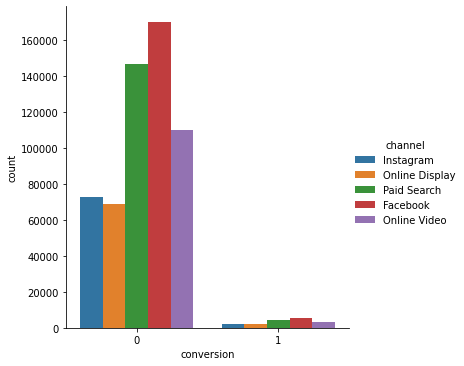

In [46]:
sns.catplot(data=df, x='conversion', kind='count', hue='channel')

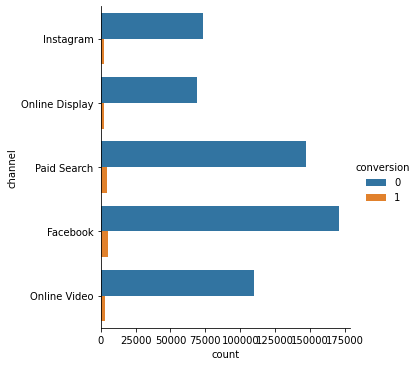

In [47]:
sns.catplot(data=df, hue='conversion', kind='count', y='channel')

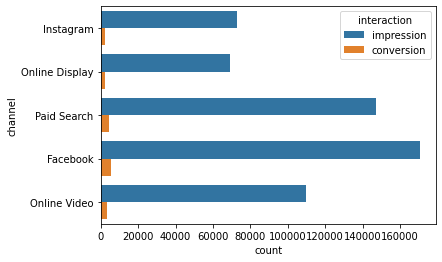

In [48]:
sns.countplot(data=df, hue='interaction', y='channel');

need to show values and compare conversion % between insta/facevbook/ paid search etc. 

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

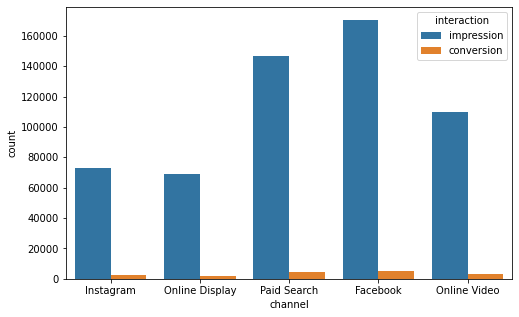

In [49]:
plt.figure(figsize = (8,5))
# ax=sns.countplot(y='Origin',x='Quantity',data= n_data,orient='h',
#            estimator =sum )
ax= sns.countplot(data=df, hue='interaction', x='channel')
#ax.bar_label(ax.containers[0],size = 13)
for i in ax.containers:
    ax.bar_label(i,)
sns.despine(left = True,bottom=True)
ax.set(xlabel=None)
ax.set(ylabel=None)
#ax.set(xticklabels=[])
ax.set(yticks=[])
#plt.ylabel('Origin',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Which chanel gives us more conversion ?

In [ ]:
df.columns

Index(['cookie', 'time', 'interaction', 'conversion', 'conversion_value',
       'channel', 'hour', 'mins', 'day', 'month', 'year', 'dayofweek',
       'day_name', 'month_name'],
      dtype='object')

In [52]:
channel_inter_df = df[df['interaction'] == 'conversion']\
 .groupby('channel')[['interaction']].count()\
 .sort_values(by='interaction', ascending=False)\
 .reset_index()\
 .rename(columns={'interaction':'count'})

In [53]:
channel_inter_df

,channel,count
0,Facebook,5301
1,Paid Search,4547
2,Online Video,3408
3,Instagram,2244
4,Online Display,2139


AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

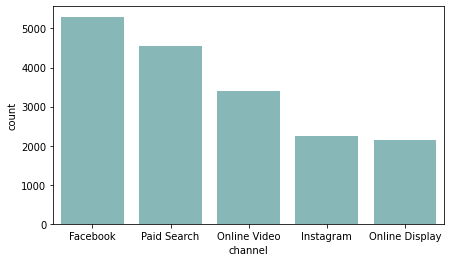

In [54]:
plt.figure(figsize = (7,4))
# ax=sns.countplot(y='Origin',x='Quantity',data= n_data,orient='h',
#            estimator =sum )
ax= sns.barplot(data=channel_inter_df, x='channel',y='count',color='teal',alpha=0.5)
#ax.bar_label(ax.containers[0],size = 13)
for i in ax.containers:
    ax.bar_label(i,)
sns.despine(left = True,bottom=True)
ax.set(xlabel=None)
ax.set(ylabel=None)
#ax.set(xticklabels=[])
ax.set(yticks=[])
#plt.ylabel('Origin',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Which Months give is peek conversations ?


In [ ]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,hour,mins,day,month,year,dayofweek,day_name,month_name
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,13,2,3,7,2018,1,Tuesday,July
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,19,15,17,7,2018,1,Tuesday,July
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,15,51,24,7,2018,1,Tuesday,July
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,7,44,29,7,2018,6,Sunday,July
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,9,44,3,7,2018,1,Tuesday,July


In [ ]:
day_inter_df = df[df['conversion'] == 1]\
 .groupby(['dayofweek','day_name'])[['interaction']].count()\
 .reset_index()\
 .rename(columns={'interaction':'count'})

In [ ]:
day_inter_df

,dayofweek,day_name,count
0,0,Monday,2820
1,1,Tuesday,2575
2,2,Wednesday,2645
3,3,Thursday,2397
4,4,Friday,2017
5,5,Saturday,2339
6,6,Sunday,2846


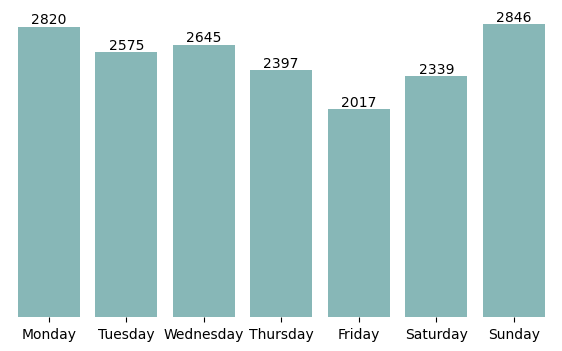

In [ ]:
plt.figure(figsize = (7,4))
# ax=sns.countplot(y='Origin',x='Quantity',data= n_data,orient='h',
#            estimator =sum )
ax= sns.barplot(data=day_inter_df, x='day_name',y='count',color='teal',alpha=0.5)
#ax.bar_label(ax.containers[0],size = 13)
for i in ax.containers:
    ax.bar_label(i,)
sns.despine(left = True,bottom=True)
ax.set(xlabel=None)
ax.set(ylabel=None)
#ax.set(xticklabels=[])
ax.set(yticks=[])
#plt.ylabel('Origin',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [ ]:
hour_inter_df = df[df['conversion'] == 1]\
 .groupby(['hour'])[['interaction']].count()\
 .reset_index()\
 .rename(columns={'interaction':'count'})

In [ ]:
hour_inter_df 

,hour,count
0,0,205
1,1,86
2,2,45
3,3,30
4,4,39
5,5,149
6,6,293
7,7,662
8,8,861
9,9,1097


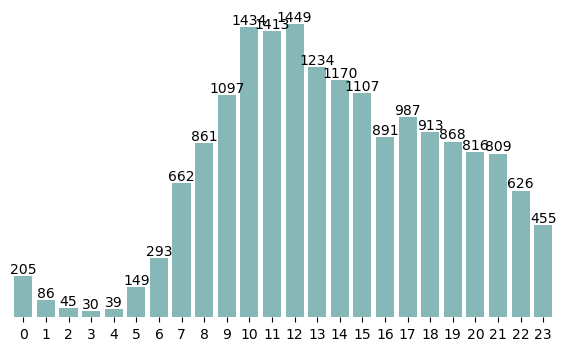

In [ ]:
plt.figure(figsize = (7,4))
# ax=sns.countplot(y='Origin',x='Quantity',data= n_data,orient='h',
#            estimator =sum )
ax= sns.barplot(data=hour_inter_df, x='hour',y='count',color='teal',alpha=0.5)
#ax.bar_label(ax.containers[0],size = 13)
for i in ax.containers:
    ax.bar_label(i,)
sns.despine(left = True,bottom=True)
ax.set(xlabel=None)
ax.set(ylabel=None)
#ax.set(xticklabels=[])
ax.set(yticks=[])
#plt.ylabel('Origin',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [ ]:
plt.figure(figsize = (7,4))
# ax=sns.countplot(y='Origin',x='Quantity',data= n_data,orient='h',
#            estimator =sum )
ax= sns.barplot(data=day_inter_df, x='day_name',y='count',color='teal',alpha=0.5)
#ax.bar_label(ax.containers[0],size = 13)
for i in ax.containers:
    ax.bar_label(i,)
sns.despine(left = True,bottom=True)
ax.set(xlabel=None)
ax.set(ylabel=None)
#ax.set(xticklabels=[])
ax.set(yticks=[])
#plt.ylabel('Origin',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [ ]:
day_inter_df

,day_name,count
0,Friday,2017
1,Monday,2820
2,Saturday,2339
3,Sunday,2846
4,Thursday,2397
5,Tuesday,2575
6,Wednesday,2645


In [ ]:
df['month_name'].unique()

array(['July'], dtype=object)

#### Is their an underlying trend on each channel ?

In [ ]:
conversion_trend_df = df[df['conversion'] == 1]\
.groupby(['hour','channel'])[['interaction']].count()\
.reset_index()\
.rename(columns={'interaction':'count'})

In [ ]:
conversion_trend_df

,hour,channel,count
0,0,Facebook,78
1,0,Instagram,35
2,0,Online Display,9
3,0,Online Video,48
4,0,Paid Search,35
...,...,...,...
114,23,Facebook,146
115,23,Instagram,71
116,23,Online Display,58
117,23,Online Video,119


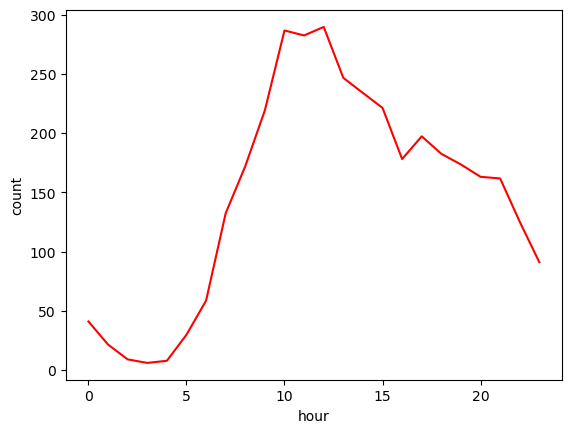

In [ ]:
sns.lineplot(x='hour',y='count',
             data =conversion_trend_df,
             errorbar=None,
            color='red');

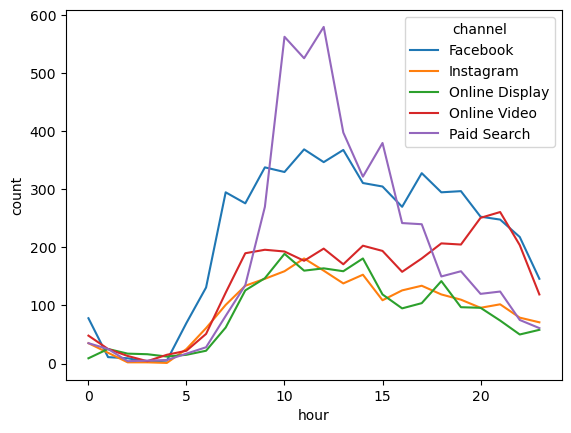

In [ ]:
sns.lineplot(x='hour',y='count',hue='channel',
             data =conversion_trend_df,
             errorbar=None,
            color='red',
            markers='*');

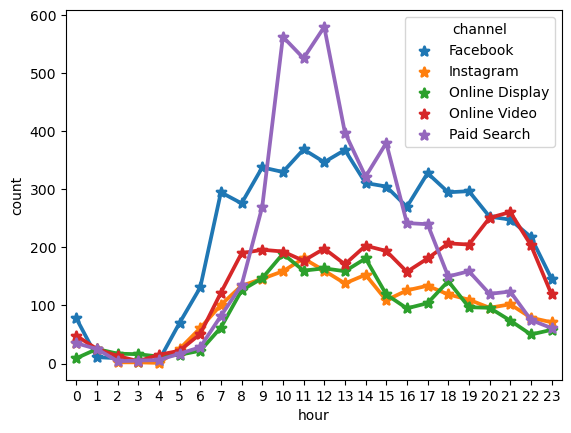

In [ ]:

sns.pointplot(x='hour',y='count',hue='channel',
             data =conversion_trend_df,
             errorbar=None,
       
            markers='*');

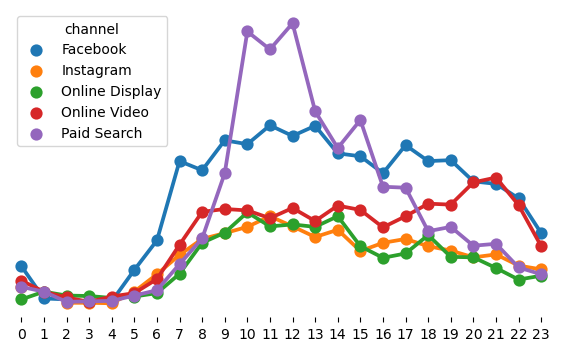

In [ ]:
plt.figure(figsize = (7,4))
# ax=sns.countplot(y='Origin',x='Quantity',data= n_data,orient='h',
#            estimator =sum )
ax= sns.pointplot(data=conversion_trend_df, x='hour',y='count',hue='channel')
#ax.bar_label(ax.containers[0],size = 13)
for i in ax.containers:
    ax.bar_label(i,)
sns.despine(left = True,bottom=True)
ax.set(xlabel=None)
ax.set(ylabel=None)
#ax.set(xticklabels=[])
ax.set(yticks=[])
#plt.ylabel('Origin',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()